#  The code

ebolavirus_record
4
sample  0
accession  FJ217161.1
sample  1
accession  KC545393.1
sample  2
accession  KC545395.1
sample  3
accession  KC545394.1
sample  4
accession  KC545396.1
sample  5
accession  FJ217162.1
sample  6
accession  AF522874.1
sample  7
accession  AB050936.1
sample  8
accession  JX477166.1
sample  9
accession  FJ621585.1
sample  10
accession  FJ621583.1
sample  11
accession  JX477165.1
sample  12
accession  FJ968794.1
sample  13
accession  KC242783.2
sample  14
accession  EU338380.1
sample  15
accession  AY729654.1
sample  16
accession  JN638998.1
sample  17
accession  KC545389.1
sample  18
accession  KC545390.1
sample  19
accession  KC545391.1
sample  20
accession  KC545392.1
sample  21
accession  KC589025.1
sample  22
accession  KC242801.1
sample  23
accession  NC_002549.1
sample  24
accession  KC242791.1
sample  25
accession  KC242792.1
sample  26
accession  KC242793.1
sample  27
accession  KC242794.1
sample  28
accession  AY354458.1
sample  29
accession  KC242796.1

/var/folders/7w/gncshwts7nb6gn4qyks_t5jr0000gn/T/ipykernel_32185/3544142970.py:457: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, linkage_metric)


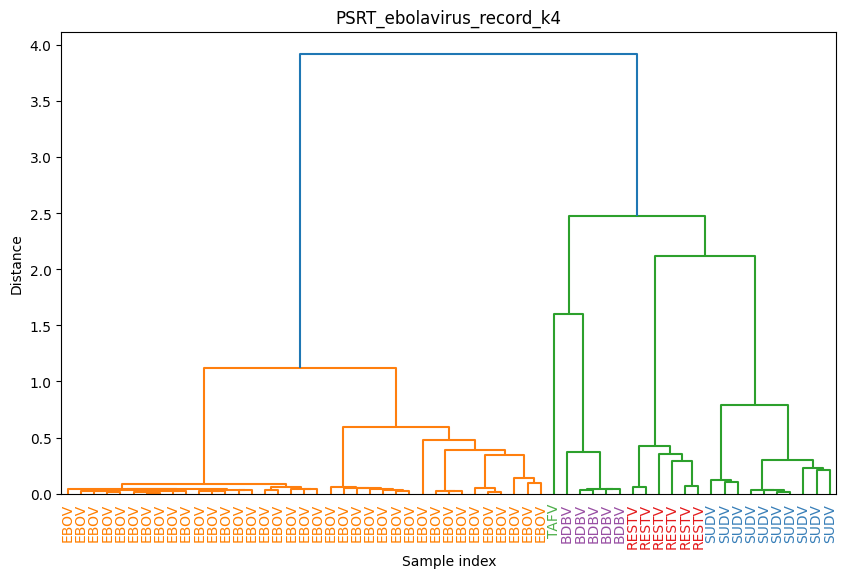

In [ ]:

# -------------------------------
# Standard libraries
# -------------------------------
import os
import sys
import random
from itertools import product

# -------------------------------
# Scientific computing
# -------------------------------
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, to_tree, dendrogram

# -------------------------------
# Bioinformatics
# -------------------------------
from Bio import SeqIO

# -------------------------------
# Machine learning
# -------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

# -------------------------------
# Visualization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Local modules
# -------------------------------
from psrt import *



encoder = "PSRT"
max_dimension = 0
num = 0
# k_chosen = 4

features_needed = [('facet', 0)]
# -------------------------------
# Configuration parameters
# -------------------------------

alphabet = ["A", "C", "G", "T"]


# # List of dataset base names (CSV and FASTA share the same prefix)

csv_names = [
    ('ebolavirus_record', 4),
    # ('bacteria_record', 4)
]

# -------------------------------
# Loop over datasets
# -------------------------------
for data_name, k_chosen in csv_names:
    print(data_name)
    path_to_data = f"./data2/{data_name}"

    # Loop over k-mer sizes from 1 to 7
    for k in range(k_chosen, k_chosen+1):
        print(k)

        # Load accessions from CSV
        df = pd.read_csv(f"{path_to_data}.csv")
        x = df['Accession (version)'].to_list()

        # Parse FASTA sequences into a list of SeqRecord objects
        file_path = f'{path_to_data}.fasta'
        DNAs = list(SeqIO.parse(file_path, "fasta"))

        # Create a dictionary: accession → SeqRecord
        dna_dict = {record.id: record for record in DNAs}

        # Match sequences with accessions from CSV, preserving order
        ordered_dnas = [dna_dict[accession] for accession in x if accession in dna_dict]
        dna_list = [str(record.seq) for record in ordered_dnas]

        # Generate all possible k-mers of length k
        kmers = generate_all_kmers(alphabet, k)

        # Define filtration values (uniform grid scaled by 4^k)
        specific_filtration = np.array([i * 4**k for i in range(0, num + 1)])
        # specific_filtration = np.array([integ for integ in range(21)])

        # -------------------------------
        # Process each DNA sequence
        # -------------------------------
        for i in range(len(dna_list)):
        # for i in range(a, min(b, len(dna_list))):
            print("sample ", i)
            print("accession ", ordered_dnas[i].id)
            dna = dna_list[i]  # ← fix: define current sequence

            # Initialize per-dimension feature accumulators
            betti_result = (max_dimension + 1) * [None]
            f_result = (max_dimension + 1) * [None]
            h_result = (max_dimension + 2) * [None]
            facet_result = (max_dimension + 1) * [None]

            # -------------------------------
            # Loop over all possible k-mers
            # -------------------------------
            for kmer in kmers:
                points = occurrence(dna, kmer)

                # Handle case where k-mer is absent
                if len(points) == 0:
                    zero_curve = np.zeros(specific_filtration.shape, dtype=float)
                    betti_curves = (max_dimension + 1) * [zero_curve]
                    f_curves = (max_dimension + 1) * [zero_curve]
                    # h_curves = (max_dimension + 2) * [zero_curve]
                    facet_curves = (max_dimension + 1) * [zero_curve]

                    # Append zero curves to result arrays
                    for d in range(max_dimension + 1):
                        if betti_result[d] is None:
                            betti_result[d] = betti_curves[d]
                        else:
                            betti_result[d] = np.vstack([betti_result[d], betti_curves[d]])

                        if f_result[d] is None:
                            f_result[d] = f_curves[d]
                        else:
                            f_result[d] = np.vstack([f_result[d], f_curves[d]])

                        if facet_result[d] is None:
                            facet_result[d] = facet_curves[d]
                        else:
                            facet_result[d] = np.vstack([facet_result[d], facet_curves[d]])

                    # Append zero curves to result arrays
                    for d in range(max_dimension + 2):
                        if h_result[d] is None:
                            h_result[d] = h_curves[d]
                        else:
                            h_result[d] = np.vstack([h_result[d], h_curves[d]])
                    continue

                # -------------------------------
                # Compute PH features for current k-mer
                # -------------------------------
                points = np.array(points)[:, np.newaxis]  # Reshape to 2D

                ph = PH(
                    points,
                    max_dimension=max_dimension,
                    max_edge_length=2.0,
                    specific_filtration=specific_filtration
                )

                alphas, betti_curves = ph.betti_curves()
                f_curves = ph.compute_f_vector_curves()
                h_curves = ph.compute_h_vector_curves()
                facet_curves = ph.facet_curves()

                # Stack curves per dimension
                for d in range(max_dimension + 1):
                    if betti_result[d] is None:
                        betti_result[d] = betti_curves.get(d, np.zeros_like(alphas))
                    else:
                        betti_result[d] = np.vstack([betti_result[d], betti_curves.get(d, np.zeros_like(alphas))])

                    if f_result[d] is None:
                        f_result[d] = f_curves.get(d, np.zeros_like(alphas))
                    else:
                        f_result[d] = np.vstack([f_result[d], f_curves.get(d, np.zeros_like(alphas))])

                    if facet_result[d] is None:
                        facet_result[d] = facet_curves.get(d, np.zeros_like(alphas))
                    else:
                        facet_result[d] = np.vstack([facet_result[d], facet_curves.get(d, np.zeros_like(alphas))])

                # Stack curves per dimension
                for d in range(max_dimension + 2):
                    if h_result[d] is None:
                        h_result[d] = h_curves.get(d, np.zeros_like(alphas))
                    else:
                        h_result[d] = np.vstack([h_result[d], h_curves.get(d, np.zeros_like(alphas))])

            # -------------------------------
            # Save results to .npy files
            # -------------------------------
            save_path = f"features2/{encoder}/{data_name}/{k}"
            os.makedirs(save_path, exist_ok=True)   # create folder path if missing
            for d in range(max_dimension+1):
                np.save(f"./features2/{encoder}/{data_name}/{k}/{x[i]}_betti{d}.npy", betti_result[d])
                np.save(f"./features2/{encoder}/{data_name}/{k}/{x[i]}_f{d}", f_result[d])
                np.save(f"./features2/{encoder}/{data_name}/{k}/{x[i]}_facet{d}", facet_result[d])

            # -------------------------------
            # Save results to .npy files
            # -------------------------------
            for d in range(max_dimension+2):
                np.save(f"./features2/{encoder}/{data_name}/{k}/{x[i]}_h{d}", h_result[d])



















def stack_arrays_vertically(file_paths):
    """
    Load NumPy arrays from given file paths and stack them vertically.

    Parameters:
        file_paths (list of str): List of file paths to the NumPy arrays.

    Returns:
        np.ndarray: A single vertically stacked NumPy array.
    """
    # Load each array and store it in a list
    # arrays = [np.load(path) for path in file_paths]
    arrays = [np.load(path).reshape(-1) for path in file_paths]
    
    # Stack the arrays vertically
    stacked_array = np.vstack(arrays)
    
    return stacked_array





for data_name, k_chosen in csv_names:
    print(data_name)
    for k in range(k_chosen,k_chosen+1):
        print(k)
        path_to_features = f'features2/{encoder}/{data_name}/{k}'
        path_to_data = f'data2/{data_name}'

        # Read CSV file into DataFrame
        df = pd.read_csv(f"{path_to_data}.csv")
        # Load and sort accession IDs from metadata
        accessions = df['Accession (version)'].to_list()

        # Path to folder with feature files
        folder_path = path_to_features

        for considered_feature, considered_max_dimension in features_needed:
            print(considered_feature, considered_max_dimension)
            for d in range(considered_max_dimension+1):
                print("d ", d)

                # List all betti0 .npy files
                file_names = [
                    f for f in os.listdir(folder_path)
                    if f.endswith('.npy') and f'{considered_feature}{d}' in f and os.path.isfile(os.path.join(folder_path, f))
                ]

                # Extract accession IDs from filenames (assumes format: accession_betti0.npy)
                modified_names = [f.rsplit(f'_{considered_feature}{d}', 1)[0] for f in file_names]

                # Filter accession IDs that have corresponding feature files
                matched_accessions = [acc for acc in accessions if acc in modified_names]
                print("accessions ", len(accessions))
                print("matched" , len(matched_accessions))

                # Map accession → index in file_names
                element_to_index = {name: idx for idx, name in enumerate(modified_names)}

                # Build index list (skip any accessions not found in file_names)
                indices = [element_to_index[acc] for acc in matched_accessions if acc in element_to_index]

                # Sort file names to match accession order
                file_names_sorted = [file_names[i] for i in indices]

                # Full paths to sorted .npy files
                file_paths = [os.path.join(folder_path, fname) for fname in file_names_sorted]

                np.save(f'features2/{encoder}/{data_name}/k{k}_{considered_feature}{d}.npy', stack_arrays_vertically(file_paths))


















# -------------------------------
# Distance Computation Function
# -------------------------------
def compute_pairwise_distances(X, metric='euclidean', **kwargs):
    """
    Compute pairwise distances for the dataset X.

    Args:
        X (ndarray): Dataset of shape (N, D), where N is the number of samples
                     and D is the number of features.
        metric (str): Distance metric to use. Supported metrics:
                      'euclidean', 'manhattan', 'cosine', 'chebyshev',
                      'minkowski', 'hamming', 'jaccard'.
        kwargs: Additional arguments for specific metrics (e.g., p for Minkowski).

    Returns:
        distance_matrix (ndarray): Pairwise distance matrix of shape (N, N).
    """
    # Compute condensed distance matrix using pdist
    condensed_dist = pdist(X, metric=metric, **kwargs)
    # Convert condensed form to square form
    distance_matrix = squareform(condensed_dist)
    return distance_matrix

# -------------------------------
# Main Script
# -------------------------------

print(f"Encoder: {encoder}")

for data_name, k_chosen in csv_names:
    print(f"Dataset: {data_name}")

    for k in range(k_chosen, k_chosen + 1):
        print(f"k = {k}")

        for feature, max_dim in features_needed:
            print(f"  Feature: {feature}")

            for d in range(max_dim + 1):
                input_path = f'features2/{encoder}/{data_name}/k{k}_{feature}{d}.npy'

                if not os.path.exists(input_path):
                    print(f"    [Skipped] File not found: {input_path}")
                    continue

                # Load and normalize data
                X = np.load(input_path)
                X = X/np.max(X)
                # X = StandardScaler().fit_transform(X)

                # Compute distance matrix
                metric = 'minkowski'
                p = 2
                print(f"    Computing pairwise distances (metric: {metric})...")
                dist_matrix = compute_pairwise_distances(X, metric=metric, p=p)
                dist_matrix = dist_matrix/np.max(dist_matrix)
                # dist_matrix /= np.max(dist_matrix)

                # Save output
                output_dir = f'distances2/{encoder}/{data_name}'
                os.makedirs(output_dir, exist_ok=True)
                output_path = f'{output_dir}/k{k}_distance_{feature}{d}.npy'
                np.save(output_path, dist_matrix)

                print(f"    [Saved] {output_path}")

            print("  " + "-" * 50)
        print("=" * 60)






















